# <center> Level 1: Local Frog Discovery Tool </center>

##  <center> Team : Data_Ninjas </center>

## Table of Contents

* [Problem Understanding](#pu)
    * [Problem Statement](#ps)
    * [Challenge Aim](#hs)
    * [Load Dependencies](#pg)
    
        
* [Data Input](#dip)
    * [Response Variable](#rva)
    * [Data Sampling](#dsa)
    * [Addressing Bias](#adb)
    * [Sampling Bias](#sab)
    * [Class Balancing](#clb)
    * [Predictor Variable](#pva)
    
    
* [Data Preparation](#dp)
    * [Feature Exploration](#fex)
    * [Data Cleaning](#dcl)
    * [Balancing Technique](#dcp)
    
    
* [Feature Selection](#fse)
    * [Correlation](#corr)
        
        
* [Model Building](#mob)
    * [Model Selection](#mos)
    * [Parameter Tuning](#ptu)
    * [Model Training](#mdt)
    * [Model Prediction](#mpr)
    * [Model Evaluation](#mde)
    * [Saving Model](#smo)


# 1. Problem Understanding <a id='pu'></a>

## Challenge Level 1 Overview

### 1.1 Problem Statement <a id='ps'></a>


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>



As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km), predicting one species against the rest of the 5 specified Australian species using only [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) predictor variables. In this project, we will be using four features from the TerraClimate dataset, the maximum monthly temperature, the minimum monthly temperature, the mean monthly precipitation, and the mean soil moisture, and will train an SDM model with these data. The TerraClimate data is sampled at a monthly temporal resolution, so metrics are calculated over the time dimension to simplify the features. For this analysis we use a ten year window from the start of 2010 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 


### 1.2 Challenge Aim <a id='pg'></a>

To develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

### 1.3 Load in dependencies <a id='lid' ></a>

To run this notebook, you will need to have the following packages imported below installed. This may take a while. 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np
import seaborn as snb

# Machine Learning
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from scipy import stats
from sklearn.model_selection import cross_val_score
import pickle 

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle


# Path to data folder with provided material

data_path = '../'

<br>

# 2. Data Input  <a id='dip'> </a>

### 2.1 Response Variable <a id='rva'> </a>

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within the region of interest.


In [2]:
if not os.path.exists(data_path + 'training_data/'):
    os.mkdir(data_path + 'training_data/')
    with zipfile.ZipFile(data_path +'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path + 'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### 2.2 Data Sampling <a id='dsa'> </a>


#### Spatial Sampling 

For our training dataset, we will constrain our search to frogs in the entire Australia between the start of 2010 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas, and also a larger dataset.

#### Date sampling

To have a large dataset, and improve our model, we have decided to choose an interval of 10 years occurence data for 2010-2019, this also because in the frog occurence notebook, the Litoria Fallax over time is high between this period.

In [3]:
# Define the bounding box for all of Australia:

region_name = 'Australia'
min_lon, min_lat = (110.534538, -41.655134)  # Lower-left corner 
max_lon, max_lat = (156.066598, -9.435397)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2010, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193707,2420099493,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.734715,144.328494,Crinia Signifera
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera


### 2.3 Addressing Bias <a id='adb'> </a>

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

In [4]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}",fontsize=20)
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}",fontsize=20)
    cx.add_basemap(ax[0],  **cmap_params) # Add basemap crs={'init':'epsg:4326'},
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of the area. Here, the five Australian species are present: Crinia Signifera, Litoria Fallax, Crinia Glauerti, Ranoidea Australis, Austrochaperina .

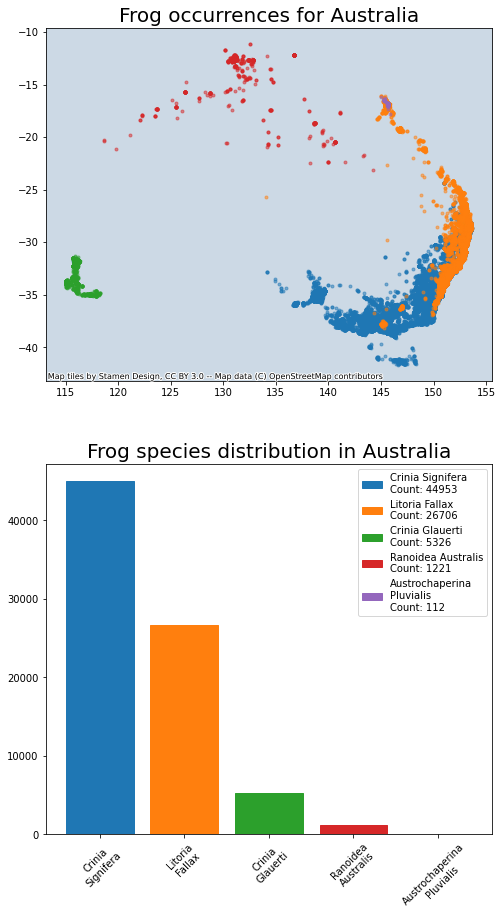

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

### 2.3 Sampling Bias <a id='sab'> </a>

The method used to address the sampling bias is called **pseudo-absence**, this technique use the occurrence points of other species as absence points for the target species. 

For this notebook, we will use the other species, Crinia Signifera, Crinia Glauerti, Ranoidea Australis, Austrochaperina, as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax (i.e. is crinia signifera or any other).

In [6]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193707,2420099493,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.734715,144.328494,Crinia Signifera,0
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera,0
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera,0


In [ ]:
#frog_data

### 2.4 Class Balancing <a id='clb'> </a>

Below we will plot the occurence of the Litora Fallax frog to see if the two classes(presence and absence) balance.

The barcharts below show the response variable with the two classes.

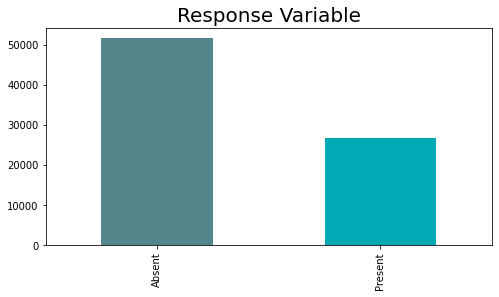

In [7]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)

c = ['#53868B', '#01A9B4']
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plt.title('Response Variable',fontsize=20)
bar_data.plot.bar(figsize=(8,4), color=c)
plt.show()


From the graph above, we can see that there is a class inbalance issue, this will br resolved at the data preparation part. Below is plotted the training set for Australia

Text(0.5, 1.0, 'Training set for Australia')

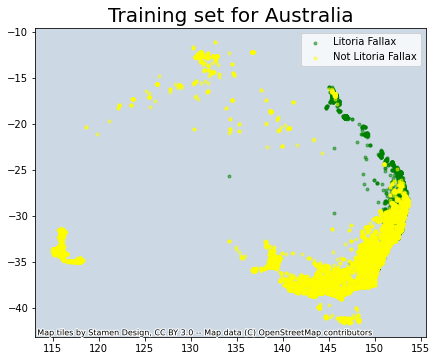

In [8]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, alpha=0.5)# crs={'init':'epsg:4326'},
ax.set_title(f"Training set for {region_name}",fontsize=20)

### 2.5 Predictor Variables <a id='pva'> </a>

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

#### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a ten years timeframe from the start of 2010 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [9]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
   
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
    
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [10]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2010-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox,tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

#### Visualising the TerraClimate Data

The spatial distribution of the four variables are displayed below.

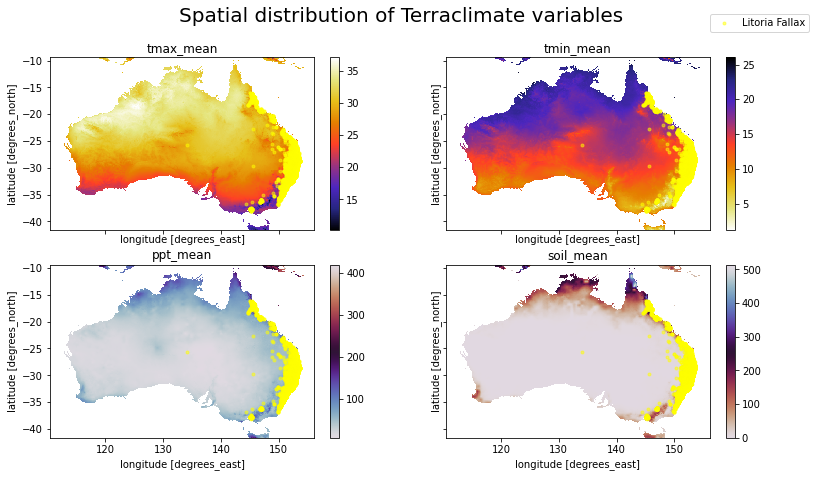

In [12]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ['CMRmap', 'CMRmap_r', "twilight", "twilight_r"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

<br>

# 3. Data Preparation <a id='dpa'> </a>

### 3.1 Feature Exploration  <a id='fex'> </a>

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so we might want to address this when training our our model.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

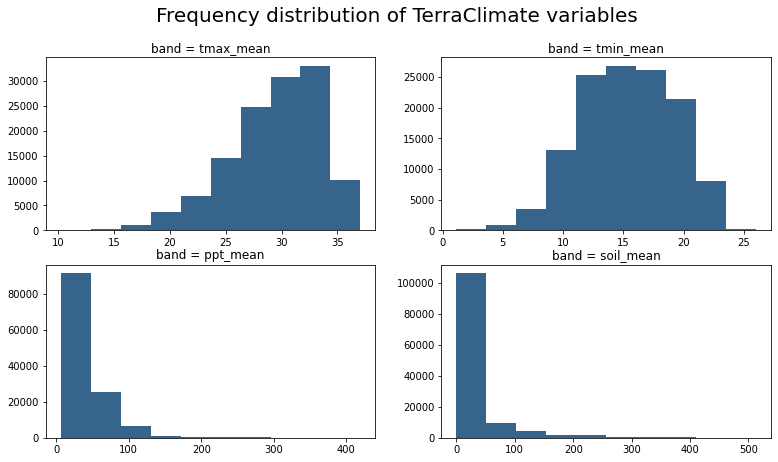

In [13]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))
bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol], color='#36648B')

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

#### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [14]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0,NaN,NaN,NaN,NaN
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1,89.633331,80.833336,23.335836,13.569169
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2,80.491669,78.583336,24.486668,11.747501
3,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1,3,81.800003,74.091667,23.690001,13.346668
4,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1,4,81.033333,65.633331,23.602503,12.817502


### 3.2 Data Cleaning <a id='dcl'> </a>

Under the data cleaning process, we first of all dropped off the columns not needed for training our model, and thereafter checked the missing values of the data so as to find an suitable way to fill them. We then decided to use an appropriate way to deal with the class imbalance problem to help train and enhance the performance of our model.

In [15]:
# Droping unwanted columns
model_data.drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'key'],1, inplace=True)

#### Missing Values

In [16]:
missing_columns = model_data.isnull().sum()
print('Missing values per column')
print(missing_columns)
total_missing = missing_columns.sum()
print()
print('The total missing values in the dataset is', total_missing)
print()
print('***********************************************************************')
print('***********************************************************************')
total_cells = np.product(model_data.shape)
percent = (total_missing/total_cells)*100
print("The percentage of missing data is","%.3f%%" %(percent))

Missing values per column
occurrenceStatus      0
ppt_mean            894
soil_mean           894
tmax_mean           894
tmin_mean           894
dtype: int64

The total missing values in the dataset is 3576

***********************************************************************
***********************************************************************
The percentage of missing data is 0.913%


The training dataset does not contain a lot of missing values, it has less 1% of missing values. To solve this we will use statistical imputation technique.

#### Data Imputation

For the data imputation we will fill the missing values of predictors variables with median and mean based on the occurence and the distribution of the features. 

In [17]:
# Filling Missing values of predictor variables based on distribution

model_data["ppt_mean"].fillna(model_data.groupby('occurrenceStatus')['ppt_mean'].transform("median"),inplace=True)
model_data["soil_mean"].fillna(model_data.groupby('occurrenceStatus')['soil_mean'].transform("median"),inplace=True)
model_data["tmax_mean"].fillna(model_data.groupby('occurrenceStatus')['tmax_mean'].transform("median"),inplace=True)
model_data["tmin_mean"].fillna(model_data.groupby('occurrenceStatus')['tmin_mean'].transform("mean"),inplace=True)

In [18]:
# Confirming number of missing values
print(model_data.isnull().sum())

occurrenceStatus    0
ppt_mean            0
soil_mean           0
tmax_mean           0
tmin_mean           0
dtype: int64


### 3.3 Balancing Technique

In order to solve the class imbalance nature of the dataset, we used SMOTE(Synthetic Minority Over-sampling Technique) to up-sample the target specie so that their numbers match that of the other species. This technique we believe is effective as synthetic samples are generated for the minority class.

Before OverSampling, counts of label '1': 26706
Before OverSampling, counts of label '0': 51612 

After OverSampling, the shape of train_X: (103224, 4)
After OverSampling, the shape of train_y: (103224,) 

After OverSampling, counts of label '1': 51612
After OverSampling, counts of label '0': 51612


Text(0.5, 1.0, 'Balanced Training Set')

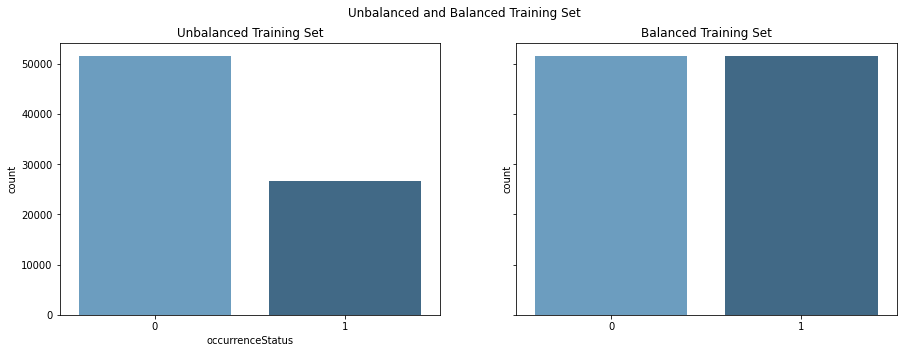

In [19]:
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['occurrenceStatus'], 1)
)
y = model_data.occurrenceStatus.astype(int)
print("Before OverSampling, counts of label '1': {}".format(sum(y == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))
#snb.countplot(x = y, palette="Blues_d")

sm = SMOTE(random_state = 2)
X_data, y_data = sm.fit_resample(X,y.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_data.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_data.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_data == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_data == 0)))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Unbalanced and Balanced Training Set')

snb.countplot(ax = axes[0], x = y,  palette="Blues_d")
axes[0].set_title('Unbalanced Training Set')

snb.countplot(ax = axes[1], x = y_data, palette="Blues_d")
axes[1].set_title('Balanced Training Set')

We have finaly resolve the inbalanced class issue by upsampling the target specie as we can see on the graph above.  

# 4. Feature Selection <a id='fse'> </a>

### Mutual Information

The Mutual Information tells the amount of information we can obtain from one random variable given another. Here we will find mutual information between the target and the features.

Feature 0: 0.362701
Feature 1: 0.366232
Feature 2: 0.377767
Feature 3: 0.375308


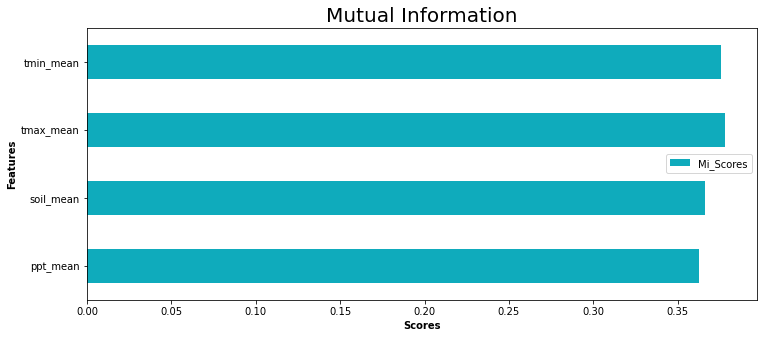

In [22]:
def select_features_Mi(X, y, discrete_features):
    fs = SelectKBest(score_func = mutual_info_classif, k = 4)
    fs.fit(X, y)
    X_fs = fs.transform(X)
    return X_fs, fs
X_fs_Mi, fs_Mi = select_features_Mi(X_data, y_data, discrete_features=[1,2,3,4] )

# what are scores for the features
for i in range(len(fs_Mi.scores_)):
    #print(i)
    print('Feature %d: %f' % (i, fs_Mi.scores_[i]))
    
# plot the scores

Mi_table = pd.DataFrame(np.array(fs_Mi.scores_),index=['ppt_mean','soil_mean',"tmax_mean","tmin_mean"], columns=['Mi_Scores'])

Mi_table.plot.barh(figsize=(12,5), color='#0FABBC')

plt.title("Mutual Information",fontsize=20)
plt.xlabel('Scores', fontdict={'fontweight':'bold'})
plt.ylabel('Features', fontdict={'fontweight':'bold'})
plt.show()

The mutual information is giving the result of 0.360770 for ppt_mean, 0.367247 for soil_mean, 0.377173 for tmax_mean and 
0.377552 for tmin_mean, which means that the four features are informative features. 

## Correlation <a id='corr'> </a>
Correlation is used to find if there is any relationship between our target and the features and if this relashioship is strong or not.

           Occurence_Correlation  P_value
ppt_mean                0.355091      0.0
soil_mean               0.250313      0.0
tmax_mean               0.380096      0.0
tmin_mean               0.442001      0.0


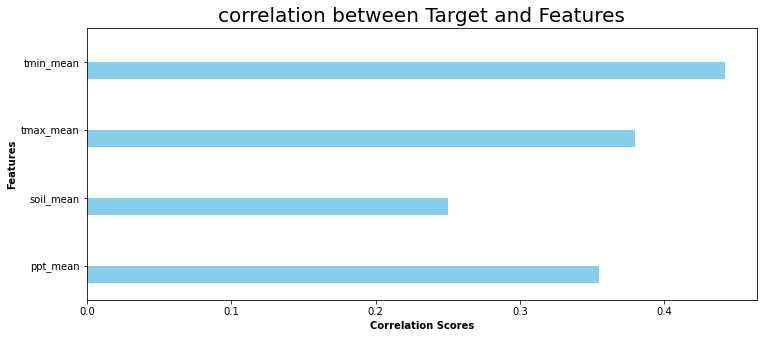

In [24]:
results = []
results.append(stats.pointbiserialr(y_data, X_data["ppt_mean"]))
results.append(stats.pointbiserialr(y_data, X_data["soil_mean"]))
results.append(stats.pointbiserialr(y_data, X_data["tmax_mean"]))
results.append(stats.pointbiserialr(y_data, X_data["tmin_mean"]))
corr_table = pd.DataFrame(np.array(results),index=['ppt_mean','soil_mean',"tmax_mean","tmin_mean"],columns=['Occurence_Correlation', 'P_value'])
print(corr_table)
corr_table.plot.barh(figsize=(12,5), color='#87CEEB',legend=None)

plt.title('correlation between Target and Features',fontsize=20)
plt.xlabel('Correlation Scores',fontdict={'fontweight':'bold'})
plt.ylabel('Features',fontdict={'fontweight':'bold'})
plt.show()

The graph above shows that there is a positive relationship between the target and the predictors, even though the relationship is not strong. This means that a change in one of the predictors variable will result in a change in the target in the same direction.

# 5. Model Building <a id='mob'> </a> 

Now that we have the data in a format appropriate for machine learning, we can begin training a model. We will try train few classification models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [ ]:
#full_model =  LGBMClassifier(learning_rate=0.22, n_estimators = 96, cat_smooth=10, metrics='binary_error',
                           #scale_pos_weight= 3.6, max_depth=16, num_leaves=49, reg_lambda=0.3)

#full_model = RandomForestClassifier()
#full_model = LogisticRegression()

### 4.1 Model Selection <a id='mos'> </a>

We don't know which algorithm will do well on this dataset. Gut feel suggests Extra-trees Classifier and Random Forest Classifier will do well. We will use 10-fold cross validation to evaluate the algorithms.

We will evaluate algorithms using the Accuracy metric. This is a gross metric that will give a quick idea of how robust a given model is. 

In [25]:
# Spot-Check Algorithms
models = []
models.append(('LGBM', LGBMClassifier()))
models.append(('EXT', ExtraTreesClassifier()))
models.append(('RAD', RandomForestClassifier()))
models.append(('LOG', LogisticRegression()))

The algorithms all use default tuning parameters. Let's compare the algorithms. We will display the Accuracy and standard deviation of Accuracy for each algorithm as we calculate it and collect the results for use later.

In [32]:
def cross_val(models, folds, scoring):
    """Function for cross validation using piepelines
    Args:
        pipes - list: list of pipelines to be evaluated
    Returns:
        fig - dataframe: dataframe showing output results
    """
    results = []
    names = []
    data_list = []

    for name, m in models:
        cv_results = cross_val_score(m, X_data, y_data, cv=folds, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        data_list.append([name, round(cv_results.mean(), 4), round(cv_results.std(),4)])

    # create a dataframe for the results
    table = pd.DataFrame(np.array(data_list), columns=['model_name', 'metric_name', 'std'])
    table = table.sort_values(by='metric_name')
    #fig = ff.create_table(table)
    #fig.layout.width=500

    return table

In [33]:
fig_linear = cross_val(models, 10, 'accuracy')
fig_linear

,model_name,metric_name,std
3,LOG,0.7728,0.0285
0,LGBM,0.8533,0.0296
2,RAD,0.8566,0.0283
1,EXT,0.8572,0.0275


Based on the above algorithm evaluation, we see that `LGBM`, `RAD`, and `LOG` are likely to produce models with good `accuracy` values. However, we can see that the `ExtraTreesClassifier` is likely to produce higher score as compared to the other algorithms and upon closer look at the boxplot above, we can also see that it has high potential with less variation. LGBMClassifier also gave a relatively high score value but still less than the other better algorithms. We therefore conclude that ExtraTreesClassifier is the best algorithm for this dataset and likely to be stable based on the standard deviation.

### 4.2 Parameter Tuning <a id='ptu'> </a>

Since we have decided to use the `ExtraTreesClassifier` for our dataset, in this step, we will go ahead and find the best parameters that should be used to train our model. We will be evaluating `RandomizedSearch` methods.

In [36]:
# Using RandomizedSearchCV for best parameters

model = ExtraTreesClassifier()
skf = StratifiedKFold(n_splits=10, random_state=420, shuffle=True)
grid_params_et = [{'criterion': ['gini', 'entropy'],
                   'min_samples_leaf': [2,3,4,5,6,7,8,9,10],
                   'max_depth': [1,2,5,6,10,16,18,20,25],
                   'min_samples_split': [2,3,4,5,6,7,8,9,10]}]


grid = RandomizedSearchCV(estimator = model, scoring = 'accuracy', cv = skf, param_distributions = grid_params_et)
                   
grid_result = grid.fit(X_data, y_data)

In [37]:
# Getting best parameters and score of the model
#param_table = pd.DataFrame(np.array(data_list), columns=['model_name', 'metric_name', 'std'])

print(grid_result.best_params_)
print(grid_result.best_score_)

{'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'entropy'}
0.8567871995352292


### 4.3 Model Training <a id='mdt'> </a>

In [39]:
# Instantiating selected model on the model data
#full_model = ExtraTreesClassifier(criterion = "gini", max_depth = 18, min_samples_leaf = 5, min_samples_split = 6)
full_model = ExtraTreesClassifier(criterion = "entropy", max_depth = 25, min_samples_leaf = 3, min_samples_split = 5)

# Splitting data into train/test
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state= 22)

# Fit model
full_model.fit(x_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=25, min_samples_leaf=3,
                     min_samples_split=5)

### 4.4 Model Prediction <a id='mpr'> </a>

#### Predict Training Set

Extremely Randomized Trees Classifier(Extra Trees Classifier) is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it's classification result. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model. We will evaluate these predictions in the evaluation section of this notebook.

In [40]:
predictions = full_model.predict(x_test)

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap in the results section of this notebook.

This function will be used later to predict the test regions for the challenge. 


In [41]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band = full_model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

### 4.5 Model Evaluation <a id='mde'> </a>

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.


#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `predictions` variable. We can now calculate some performance metrics to guage the effectiveness of the model. It must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook only took naive approaches to address this. The model evaluation metrics are only as good as the data used to evaluate it, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance. 

In this example, we will use `f1_score` and `accuracy_score` from Scikit-learn. Scikit-learn provides many other metrics that can be used for evaluation. You can even code your own if you think it will assist you in evaluating your model.


#### Evaluation Metrics Details


In [42]:
print(f"F1 Score: {np.mean(f1_score(y_test, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y_test, predictions)).round(2)}")

F1 Score: 0.87
Accuracy: 0.86


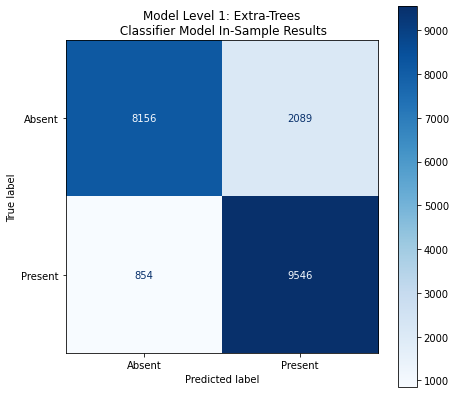

In [43]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, x_test, y_test, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Extra-Trees\n Classifier Model In-Sample Results')
plt.show()

From above, we see that the model is able to achieve a good F1 score and accuracy. From the confusion matrix, we can see that our model seems to confuse absent points with present points aka false positives for some entries, as shown in the top right corner. There may be many reasons for this, and a great way of understanding what might be causing the model's high false positive rate is to visualise its performance over the training region. We do this by plotting a probabilty heatmap in the section below.


#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly. Particularly, we are interested in the high false positive rate.

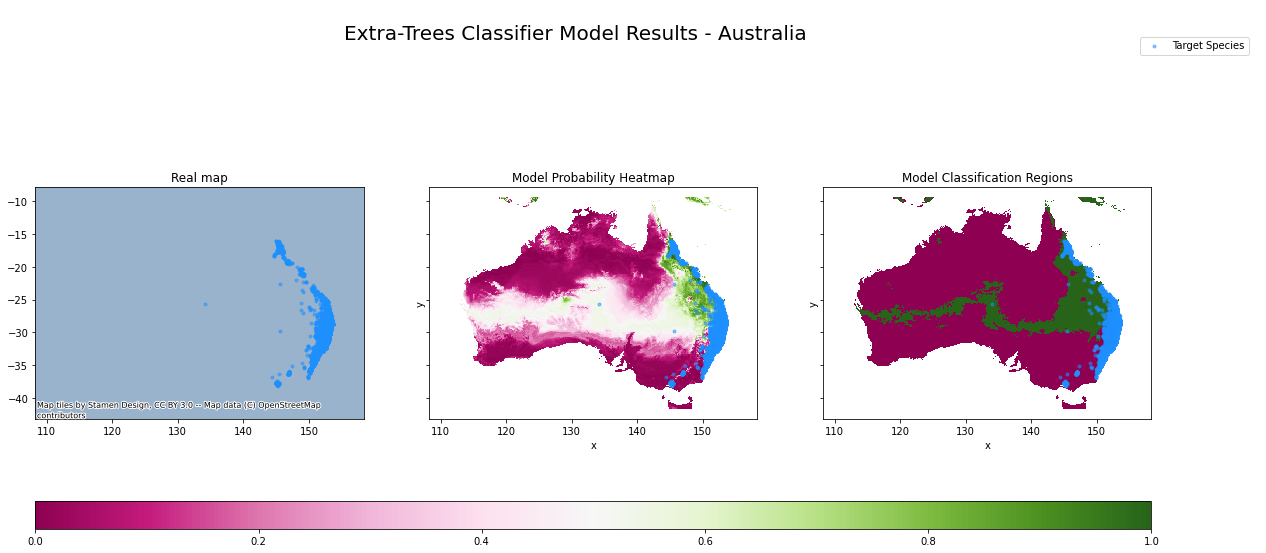

In [45]:
def plot_heatmap(resultant_image, frog_data, title):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0])
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, f"Extra-Trees Classifier Model Results - {region_name}")

From the plots above, we can see that the model does a pretty good job of mapping where litoria fallax is. However, our performance metrics before suggested otherwise.  



#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

Scikit-learn has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

Again, these metrics are derived from a biased sample, so be careful what you infer.


In [47]:
# Using Cross-Validation for out-of-sample Evaluation

cv_model = ExtraTreesClassifier(criterion = "entropy", max_depth = 25, min_samples_leaf = 3, min_samples_split = 5)

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X_data, y_data)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X_data.loc[train_index], X_data.loc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.86
Accuracy: 0.86


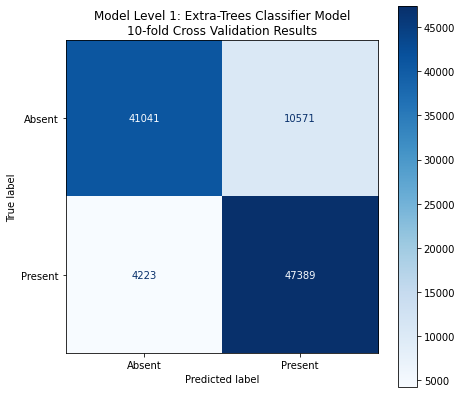

In [48]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Extra-Trees Classifier Model\n10-fold Cross Validation Results')
plt.show()

The results from the 10-fold cross validation are similar than the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the higher rate of false positives that we saw in the in-sample performance. 

### 4.6 Feature Importance <a id='fim'> </a>

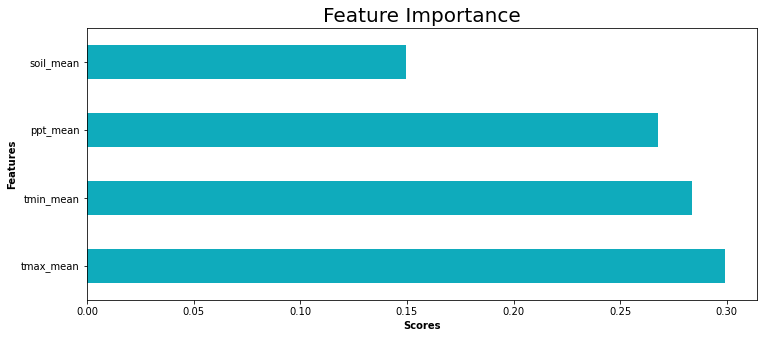

In [59]:
(pd.Series(full_model.feature_importances_, index=X.columns)
   .nlargest(4)
   .plot(kind='barh', color = '#0FABBC', figsize=(12,5)) )
plt.title("Feature Importance",fontsize=20)
plt.xlabel('Scores', fontdict={'fontweight':'bold'})
plt.ylabel('Features', fontdict={'fontweight':'bold'})
plt.show()

### 4.7 Saving Model <a id='smo'> </a>

In [60]:
# save model to pickle file to be applied on new data

def model_save(name):
    """Function to save model
    Arg:
        name: string - name to be given to the model
    Return:
        None
    """
    file_name = name

    open_file = open(file_name, "wb")
    pickle.dump(full_model, open_file)
    open_file.close()

In [61]:
# save model

model_save('Species_Dist_Model.sav')

## Happy Frogging !!!
